# Курсовая работа
по дисциплине “Технологии анализа данных и машинного обучения” \
на тему: «Машинное обучение в задачах распознавания объектов на фотографии» \

Выполнил: \
студент группы ПИ20-3 факультета информационных технологий и анализа больших данных \
Зиняков А.В.

Научный руководитель: \
доцент, к.т.н. Муминова С.Р.

### Импортирование библиотек

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torchvision
import skorch
import timeit

from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
from random import randrange
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from sklearn import model_selection

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 1.	Выбрать (собрать) набор данных для анализа в соответствии с выбранной темой курсовой работы. Описать этот набор и решаемую задачу. Определить метрики качества для модели, определить типичный уровень метрик для решения аналогичных задач, установить ориентиры для метрики.

> ### Описание датасета
> Fashion-MNIST — это набор изображений статей Zalando, состоящий из обучающего набора из 60 000 примеров и тестового набора из 10 000 примеров. Каждый пример представляет собой изображение в градациях серого 28x28, связанное с меткой из 10 классов.

> ### Решаемая задача
> Для данного датасета подходит задача множественной классификации для изображений.

> ### Предполагаемые метрики качества
> Для сверточных нейронных сетей в основном берут самую простую, но при этом не менее эффективную метрику под названием accuracy.
Возьмем минимальный уровень этой метрики в 70%+-5%, так как для более качественного результата может потребоваться большое время на вычисление и более мощный компьютер.

### 2.	Провести предварительный анализ и очистку данных. Этот этап включает в себя вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной, вывод нескольких элементов данных для иллюстрации структуры данных.

> Fashion MNIST это уже предобработанный датасет в котором присутствует нормализация и отсуствуют пропуски. \
Физически у нас есть классификатор - цифра от 0 до 9, каждая из которых обозначает класс одежды и картинки размером 1\*28\*28 или несколько массивов с числовыми значениями, каждый из которых обозначает свой пиксель в картинке. \
Так как датасет не текстовый, то о значимости для предсказания целевой переменной говорить не получится, так как нельзя сделать матрицу корреляций.

 Загрузка данных

In [2]:
#загружаем части train и test датасета Fashion MNIST
MNIST_train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download=True, train=False)

Информация о датасете

In [3]:
print("Общий размер датасета =",len(MNIST_train)+len(MNIST_test))

Общий размер датасета = 70000


In [4]:
print(len(MNIST_train.data[100]), "- размер картинки 28*28 пикселей")

28 - размер картинки 28*28 пикселей


In [5]:
# смотрим классы обучающей выборки и длина этого списка
print(f'Пример классов: {MNIST_train.targets}, длина train части классов картинок = {len(MNIST_train.targets)}')

Пример классов: tensor([9, 0, 0,  ..., 3, 0, 5]), длина train части классов картинок = 60000


Пример изображения


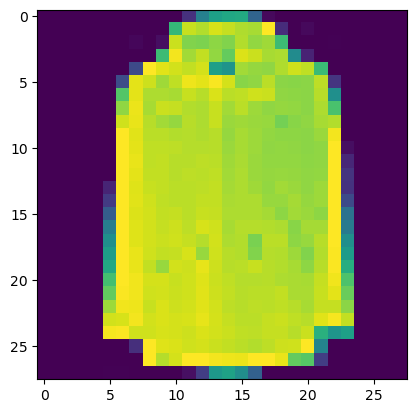

Метка - Coat


In [6]:
# пример изображения
examp=128 # константа для выбора объекта
plt.imshow(MNIST_train.data[examp])
print('Пример изображения')
plt.show()
print('Метка -', MNIST_train.classes[MNIST_train.targets[examp]])

### 3.	При необходимости выполнить преобразование данных. Этот этап сильно зависит от типа исследуемых данных и может включать в себя токинизацию и векторизацию текста, извлечение признаков из данных, преобразование изображений в плоский численный массив и другие преобразования. 
(идет после 4 пункта)

In [9]:
X_train = X_train.unsqueeze(1).float() #аналог транспонирования
X_test = X_test.unsqueeze(1).float()

### 4.	Разделить набор данных на обучающую, тестовую и валидационную выборки. Обосновать количественные характеристики и метод разделения (временной, случайный, последовательный) выборки.

In [7]:
#загружаем части train и test датасета Fashion MNIST
MNIST_train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download=True, train=False)

In [8]:
#делим train и test на x,y
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets

### 5.	Определить принципиальную архитектуру нейросетевой модели глубокого обучения, включая функцию ошибки и методы регуляризации, общую логику обучения модели. Предусмотреть возможные варианты модификации модели.
(идет после 6 пункта)

In [11]:
print('Отображение архитектуры нейронной сети')
net = MNIST_ConV()
summary(net, (1, 28, 28))

Отображение архитектуры нейронной сети
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                   [-1, 80]          32,080
              ReLU-8                   [-1, 80]               0
            Linear-9                   [-1, 40]           3,240
             ReLU-10                   [-1, 40]               0
           Linear-11                   [-1, 10]             410
Total params: 38,302
Trainable params: 38,302
Non-trainable params: 0
----------------------------------------------------------

### 6.	Реализовать модель с помощью фреймворка PyTorch. Реализация должна включать функционал загрузки данных, вывода промежуточных и финальных метрик качества и диагностических параметров процесса обучения модели. Реализация должна предусматривать гибкость, позволяющую выполнять ограниченную модификацию модели для выбора наилучшей из альтернативных архитектур.

In [10]:
class MNIST_ConV(torch.nn.Module): # наследник библиотке Module
    def __init__(self):
        super(MNIST_ConV, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2) # сверточный слой
        self.act1  = torch.nn.ReLU() # функция активации
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2) # пулинг слой
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # сверточный слой
        self.act2  = torch.nn.ReLU() # функция активации
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2) # пулинг слой
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 80) # полносвязный слой
        self.act3  = torch.nn.ReLU() # функция активации
        
        self.fc2   = torch.nn.Linear(80, 40) # полносвязный слой
        self.act4  = torch.nn.ReLU() # функция активации
        
        self.fc3   = torch.nn.Linear(40, 10) # полносвязный слой
    
    def forward(self, x):
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
mnist_conv = MNIST_ConV()

In [12]:
loss = torch.nn.CrossEntropyLoss() # оптимизатор
optimizer = torch.optim.Adam(mnist_conv.parameters(), lr=1.0e-3, betas=(0.9,0.999)) # функция потерь

### 7.	Настроить параметры входных данных и параметров для обучения. Провести обучение модели на подготовленных входных данных используя выбранные настройки и алгоритмы обучения. 

In [13]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []
train_accuracy_history = []
temp_acc=0
max_epoch=5

for epoch in range(max_epoch):
    order = np.random.permutation(len(X_train)) # определение порядка выбора данных
    temp_acc = 0
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # обязательный этап для обнуления оптимизатора
        
        batch_indexes = order[start_index:start_index+batch_size] # определение индекса батча
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = mnist_conv.forward(X_batch) # предсказание
        
        temp_acc += (preds.argmax(dim=1) == y_batch).float().mean() # промежуточная аккуратность для обучающей части
        
        loss_value = loss(preds, y_batch) # значение функции потерь
        loss_value.backward() # обратный проход
        
        optimizer.step() # обязательный этап для шага оптимизатора
        
    # следующил блок кода для записи статистики   
    train_loss_history.append(loss_value)
    test_preds = mnist_conv.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    test_loss=loss_value
    train_accuracy = temp_acc/(len(X_train)/batch_size)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(accuracy)
    print(f'Epoch:{epoch+1}/{max_epoch}, Test_accuracy = {accuracy.item()}, Test_loss = {test_loss}')

Epoch:1/5, Test_accuracy = 0.8537999987602234, Test_loss = 0.4367927312850952
Epoch:2/5, Test_accuracy = 0.871999979019165, Test_loss = 0.4353686273097992
Epoch:3/5, Test_accuracy = 0.8762000203132629, Test_loss = 0.43625408411026
Epoch:4/5, Test_accuracy = 0.8870999813079834, Test_loss = 0.3023444414138794
Epoch:5/5, Test_accuracy = 0.887499988079071, Test_loss = 0.4086836576461792


### 8.	Провести оценку качества модели с использованием предусмотренных метрик качества, проверить модель на переобучение.

In [14]:
print("Проверка на переобучение")
print('Итоговая тестовая точность =', accuracy.item())
print('Итоговая обучающая точность =', train_accuracy.item())
if train_accuracy > accuracy:
    print('Модель переобучилась так как точность обучения больше точности теста')
else:
    print("Модель не переобучилась так как точность обучения меньше точности теста")

Проверка на переобучение
Итоговая тестовая точность = 0.887499988079071
Итоговая обучающая точность = 0.8995005488395691
Модель переобучилась так как точность обучения больше точности теста


Отображение нескольких результатов предсказания


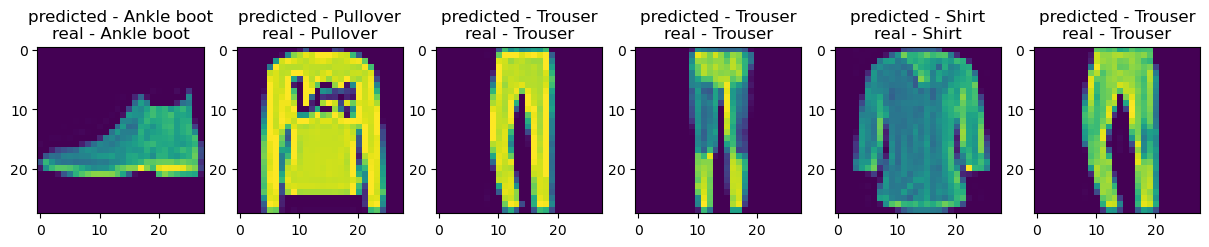

In [15]:
print('Отображение нескольких результатов предсказания')
def show_sample(model, X, y, dataset):
    y_pred = model.forward(X)
    fig, ax = plt.subplots(1, 6, figsize=(15, 3))
    for i in range(6):
        ax[i].imshow(X[i].reshape(28, 28))
        ax[i].set_title(f'predicted - {dataset.classes[y_pred[i].argmax()]}\nreal - {dataset.classes[y[i]]}')
    
show_sample(mnist_conv, X_test, y_test, MNIST_test)

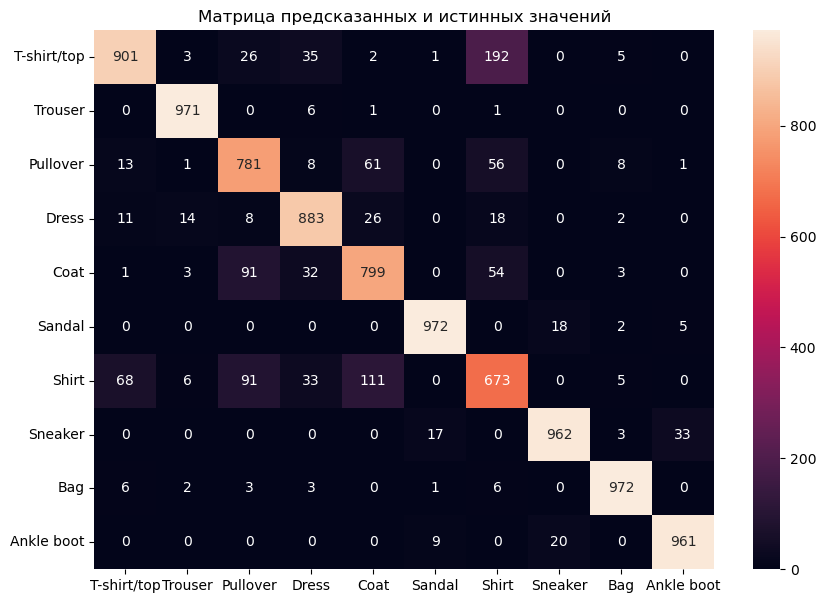

In [16]:
def show_matrix(model, X, y, dataset):
    heat_map_matrix = torch.zeros((len(dataset.classes), len(dataset.classes)))
    y_pred = model.forward(X).argmax(axis=1)
    for i in range(len(y)):
        heat_map_matrix[y_pred[i], y[i]] += 1
    heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=dataset.classes)
    heat_map_matrix.index = dataset.classes
    
    plt.figure(1, (10, 7))
    sns.heatmap(heat_map_matrix, annot=True, fmt='g')
    plt.title('Матрица предсказанных и истинных значений')
    plt.show()

show_matrix(mnist_conv, X_test, y_test, MNIST_test) 

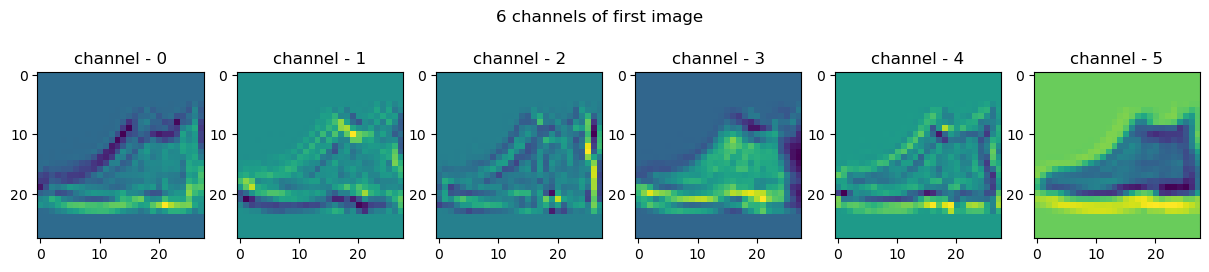

In [17]:
def show_first_conv(model, X, y, dataset):
    with torch.no_grad():
        first_conv = model.conv1(X)
        fig, ax = plt.subplots(1, first_conv[0].size(0), figsize=(15, 3))
        fig.suptitle(f'{first_conv[0].size(0)} channels of first image')
        for i in range(first_conv[0].size(0)):
            ax[i].imshow(first_conv[0][i])
            ax[i].set_title(f'channel - {i}')

show_first_conv(mnist_conv, X_test, y_test, MNIST_test)

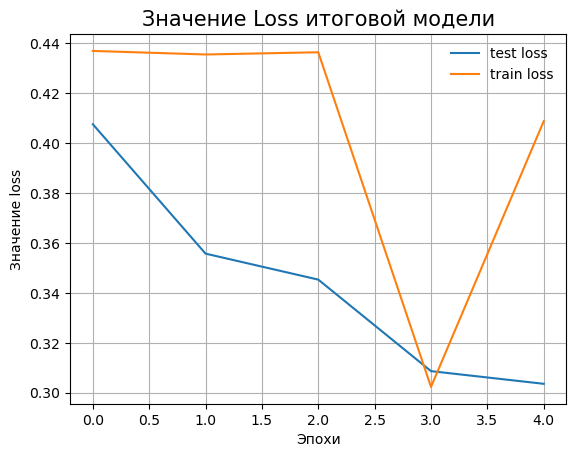

In [18]:
with torch.no_grad():
    plt.plot(test_loss_history, label="test loss")
    plt.plot(train_loss_history, label="train loss")
    
    plt.ylabel('Значение loss')
    plt.xlabel('Эпохи')

    plt.title('Значение Loss итоговой модели', fontsize=15);
    plt.legend(frameon=False);
    plt.grid(True);

    plt.show()

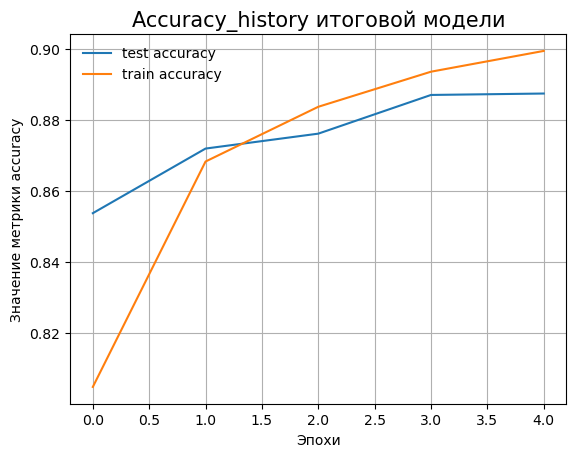

In [19]:
plt.plot(test_accuracy_history, label="test accuracy")
plt.plot(train_accuracy_history, label="train accuracy")

plt.ylabel('Значение метрики accuracy')
plt.xlabel('Эпохи')

plt.title('Accuracy_history итоговой модели', fontsize=15);
plt.legend(frameon=False);
plt.grid(True);

plt.show()

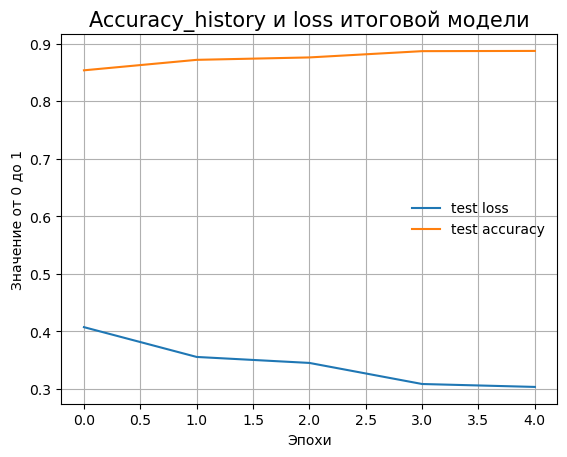

In [20]:
with torch.no_grad():
    plt.plot(test_loss_history, label="test loss")
plt.plot(test_accuracy_history, label="test accuracy")    
plt.ylabel('Значение от 0 до 1')
plt.xlabel('Эпохи')

plt.title('Accuracy_history и loss итоговой модели', fontsize=15);
plt.legend(frameon=False);
plt.grid(True);

plt.show()

### 9.	Провесит обучение и оценку качества для несколько альтернативных архитектур (вариаций архитектур) моделей (не менее 3) для решения выбранной задачи. Проанализировать результаты, сделать выводы, в том числе определить наилучшую архитектуру.

> ### Альтернативная модель 1 (убран последний слой и с функцией активации и изменен оптимизатор)

In [21]:
class MNIST_ConV_1(torch.nn.Module):
    def __init__(self):
        super(MNIST_ConV_1, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU() #функция активации
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 80)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(80, 10)
    
    def forward(self, x):
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        
        return x
    
mnist_conv_1 = MNIST_ConV_1()

In [22]:
net = MNIST_ConV_1()
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                   [-1, 80]          32,080
              ReLU-8                   [-1, 80]               0
            Linear-9                   [-1, 10]             810
Total params: 35,462
Trainable params: 35,462
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.14
Estimated Total Size (MB): 0.25
---------------------------------------------

In [23]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_conv_1.parameters(), lr=1.0e-3)

In [24]:
batch_size = 100

test_accuracy_history1 = []
test_loss_history1 = []
train_loss_history1 = []
train_accuracy_history1 = []
temp_acc1=0
max_epoch=5

for epoch in range(max_epoch):
    order = np.random.permutation(len(X_train))
    temp_acc1 = 0
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = mnist_conv_1.forward(X_batch)
        
        temp_acc1 += (preds.argmax(dim=1) == y_batch).float().mean()
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    train_loss_history1.append(loss_value)
    test_preds1 = mnist_conv_1.forward(X_test)
    test_loss_history1.append(loss(test_preds1, y_test))
    
    test_loss1=loss_value
    train_accuracy1 = temp_acc1/(len(X_train)/batch_size)
    accuracy1 = (test_preds1.argmax(dim=1) == y_test).float().mean()
    train_accuracy_history1.append(train_accuracy1)
    test_accuracy_history1.append(accuracy1)
    print(f'Epoch:{epoch+1}/{max_epoch}, Test_accuracy = {accuracy1.item()}, Test_loss = {test_loss1}')

Epoch:1/5, Test_accuracy = 0.7795000076293945, Test_loss = 0.41598185896873474
Epoch:2/5, Test_accuracy = 0.794700026512146, Test_loss = 0.4946190118789673
Epoch:3/5, Test_accuracy = 0.8260999917984009, Test_loss = 0.38777220249176025
Epoch:4/5, Test_accuracy = 0.8091999888420105, Test_loss = 0.6206232309341431
Epoch:5/5, Test_accuracy = 0.8237000107765198, Test_loss = 0.4332350790500641


In [25]:
print('Итоговая тестовая точность =', accuracy1.item())
print('Итоговая обучающая точность =', train_accuracy1.item())
if train_accuracy1 > accuracy1:
    print('Модель переобучилась так как точность обучения больше точности теста')
else:
    print("Модель не переобучилась так как точность обучения меньше точности теста")

Итоговая тестовая точность = 0.8237000107765198
Итоговая обучающая точность = 0.839948832988739
Модель переобучилась так как точность обучения больше точности теста


> ### Альтернативная модель 2 (убран второй скрытый слой и поменяна функция активации)

In [26]:
class MNIST_ConV_2(torch.nn.Module):
    def __init__(self):
        super(MNIST_ConV_2, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Softmax() #функция активации
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2)
        
        self.fc1   = torch.nn.Linear(6 * 14 * 14, 80)
        self.act3  = torch.nn.Softmax()
        
        self.fc2   = torch.nn.Linear(80, 40)
        self.act4  = torch.nn.Softmax()
        
        self.fc3   = torch.nn.Linear(40, 10)
    
    def forward(self, x):
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
mnist_conv_2 = MNIST_ConV_2()

In [27]:
net = MNIST_ConV_2()
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Softmax-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Linear-4                   [-1, 80]          94,160
           Softmax-5                   [-1, 80]               0
            Linear-6                   [-1, 40]           3,240
           Softmax-7                   [-1, 40]               0
            Linear-8                   [-1, 10]             410
Total params: 97,966
Trainable params: 97,966
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.37
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


C:\Users\aziny\AppData\Local\Temp\ipykernel_7396\3972861371.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.act1(x)
C:\Users\aziny\AppData\Local\Temp\ipykernel_7396\3972861371.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.act3(x)
C:\Users\aziny\AppData\Local\Temp\ipykernel_7396\3972861371.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.act4(x)


In [28]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_conv_2.parameters(), lr=1.0e-3, betas=(0.9,0.999))

In [29]:
batch_size = 100

test_accuracy_history2 = []
test_loss_history2 = []
train_loss_history2 = []
train_accuracy_history2 = []
temp_acc2=0
max_epoch=5

for epoch in range(max_epoch):
    order = np.random.permutation(len(X_train))
    temp_acc2 = 0
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = mnist_conv_2.forward(X_batch)
        
        temp_acc2 += (preds.argmax(dim=1) == y_batch).float().mean()
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    train_loss_history2.append(loss_value)
    test_preds2 = mnist_conv_2.forward(X_test)
    test_loss_history2.append(loss(test_preds2, y_test))
    
    test_loss2=loss_value
    train_accuracy2 = temp_acc2/(len(X_train)/batch_size)
    accuracy2 = (test_preds2.argmax(dim=1) == y_test).float().mean()
    train_accuracy_history2.append(train_accuracy2)
    test_accuracy_history2.append(accuracy2)
    print(f'Epoch:{epoch+1}/{max_epoch}, Test_accuracy = {accuracy2.item()}, Test_loss = {test_loss2}')

C:\Users\aziny\AppData\Local\Temp\ipykernel_7396\3972861371.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.act1(x)
C:\Users\aziny\AppData\Local\Temp\ipykernel_7396\3972861371.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.act3(x)
C:\Users\aziny\AppData\Local\Temp\ipykernel_7396\3972861371.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.act4(x)


Epoch:1/5, Test_accuracy = 0.5562000274658203, Test_loss = 1.9494091272354126
Epoch:2/5, Test_accuracy = 0.5705000162124634, Test_loss = 1.269008994102478
Epoch:3/5, Test_accuracy = 0.5978000164031982, Test_loss = 1.0463334321975708
Epoch:4/5, Test_accuracy = 0.6139000058174133, Test_loss = 0.8733065724372864
Epoch:5/5, Test_accuracy = 0.6531000137329102, Test_loss = 0.7328140139579773


In [30]:
print('Итоговая тестовая точность =', accuracy2.item())
print('Итоговая обучающая точность =', train_accuracy2.item())
if train_accuracy2 > accuracy2:
    print('Модель переобучилась так как точность обучения больше точности теста')
else:
    print("Модель не переобучилась так как точность обучения меньше точности теста")

Итоговая тестовая точность = 0.6531000137329102
Итоговая обучающая точность = 0.6465169787406921
Модель не переобучилась так как точность обучения меньше точности теста


> ### Альтернативная модель 3 (добавлен 3 скрытый слой, изменена функция активации и оптимизатор)

In [31]:
class MNIST_ConV_3(torch.nn.Module):
    def __init__(self):
        super(MNIST_ConV_3, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh() #функция активации
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.act3  = torch.nn.Tanh()
        
        self.fc1   = torch.nn.Linear(3 * 3 * 32, 80)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(80, 40)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(40, 10)
    
    def forward(self, x):
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
mnist_conv_3 = MNIST_ConV_3()

In [32]:
net = MNIST_ConV_3()
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 32, 3, 3]           4,640
              Tanh-8             [-1, 32, 3, 3]               0
            Linear-9                   [-1, 80]          23,120
             Tanh-10                   [-1, 80]               0
           Linear-11                   [-1, 40]           3,240
             Tanh-12                   [-1, 40]               0
           Linear-13                   [-1, 10]             410
Total params: 33,982
Trainable params: 

In [33]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_conv_3.parameters(), lr=1.0e-3)

In [34]:
batch_size = 100

test_accuracy_history3 = []
test_loss_history3 = []
train_loss_history3 = []
train_accuracy_history3 = []
temp_acc3=0
max_epoch=5

for epoch in range(max_epoch):
    order = np.random.permutation(len(X_train))
    temp_acc3 = 0
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = mnist_conv_3.forward(X_batch)
        
        temp_acc3 += (preds.argmax(dim=1) == y_batch).float().mean()
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    train_loss_history3.append(loss_value)
    test_preds3 = mnist_conv_3.forward(X_test)
    test_loss_history3.append(loss(test_preds3, y_test))
    
    test_loss3=loss_value
    train_accuracy3 = temp_acc3/(len(X_train)/batch_size)
    accuracy3 = (test_preds3.argmax(dim=1) == y_test).float().mean()
    train_accuracy_history3.append(train_accuracy3)
    test_accuracy_history3.append(accuracy3)
    print(f'Epoch:{epoch+1}/{max_epoch}, Test_accuracy = {accuracy3.item()}, Test_loss = {test_loss3}')

Epoch:1/5, Test_accuracy = 0.15780000388622284, Test_loss = 2.2670328617095947
Epoch:2/5, Test_accuracy = 0.31060001254081726, Test_loss = 2.2252938747406006
Epoch:3/5, Test_accuracy = 0.3287999927997589, Test_loss = 2.1326537132263184
Epoch:4/5, Test_accuracy = 0.34290000796318054, Test_loss = 1.8915133476257324
Epoch:5/5, Test_accuracy = 0.4088999927043915, Test_loss = 1.7872116565704346


In [35]:
print('Итоговая тестовая точность =', accuracy3.item())
print('Итоговая обучающая точность =', train_accuracy3.item())
if train_accuracy3 > accuracy3:
    print('Модель переобучилась так как точность обучения больше точности теста')
else:
    print("Модель не переобучилась так как точность обучения меньше точности теста")

Итоговая тестовая точность = 0.4088999927043915
Итоговая обучающая точность = 0.3855832815170288
Модель не переобучилась так как точность обучения меньше точности теста


> ### Выводы по архитектуре

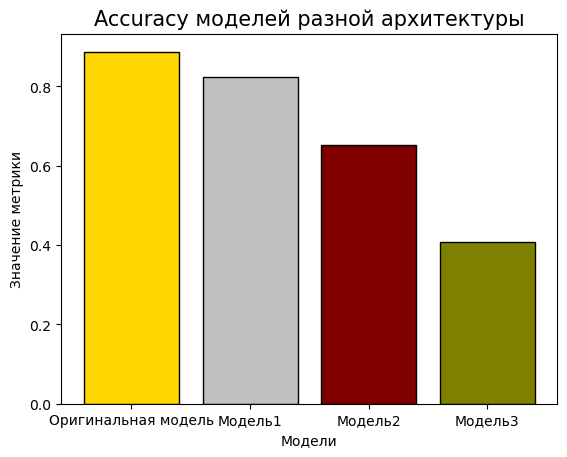

In [36]:
xx = ['Оригинальная модель','Модель1','Модель2','Модель3']
yy = [accuracy.item(),accuracy1.item(),accuracy2.item(),accuracy3.item()]

plt.bar(xx,yy, color=['gold','silver','maroon','olive'],
        edgecolor = 'black')
plt.ylabel('Значение метрики')
plt.xlabel('Модели')

plt.title('Accuracy моделей разной архитектуры', fontsize=15);

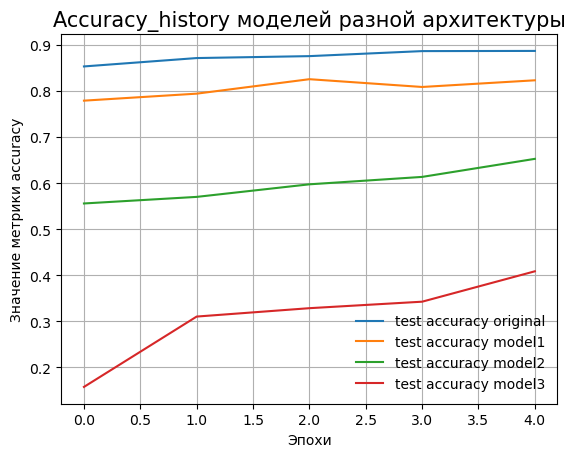

In [37]:
plt.plot(test_accuracy_history, label="test accuracy original")
plt.plot(test_accuracy_history1, label="test accuracy model1")
plt.plot(test_accuracy_history2, label="test accuracy model2")
plt.plot(test_accuracy_history3, label="test accuracy model3")

plt.ylabel('Значение метрики accuracy')
plt.xlabel('Эпохи')

plt.title('Accuracy_history моделей разной архитектуры', fontsize=15);
plt.legend(frameon=False);
plt.grid(True);

plt.show()

> Оригинальная архитектура является самое оптимальной для решения данной задачи

### 10.	Выполнить тонкую настройку модели с помощью подбора значений гиперпараметров. Провести подбор не менее трех гиперпараметров, при этом как минимум для одного подбор значения параметра выполнить в автоматическом режиме (с помощью Grid Search или аналогичных методов).

> Выполняется автоматический подбор размер батча данных, количества эпох и оптимизатора с помощью GridSearchCV

In [38]:
model = skorch.NeuralNetClassifier(
    MNIST_ConV,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam)

In [39]:
param_grid = {
    'batch_size': [50, 100],
    'max_epochs': [3, 6],
    'optimizer': [optim.SGD, optim.Adam]
}

In [40]:
print(model.initialize())

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MNIST_ConV(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act1): ReLU()
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (act2): ReLU()
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (fc1): Linear(in_features=400, out_features=80, bias=True)
    (act3): ReLU()
    (fc2): Linear(in_features=80, out_features=40, bias=True)
    (act4): ReLU()
    (fc3): Linear(in_features=40, out_features=10, bias=True)
  ),
)


In [41]:
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6033       0.8440        0.4419  17.7683
      2        0.4210       0.8658        0.3769  17.3913
      3        0.3688       0.8737        0.3508  17.9057
      4        0.3358       0.8829        0.3320  17.7219
      5        0.3131       0.8878        0.3235  17.5095
      6        0.2942       0.8895        0.3172  17.6868


In [42]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855883 using {'batch_size': 50, 'max_epochs': 6, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.831183 (0.039657) with: {'batch_size': 50, 'max_epochs': 3, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.821700 (0.012944) with: {'batch_size': 50, 'max_epochs': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.855883 (0.032521) with: {'batch_size': 50, 'max_epochs': 6, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.833517 (0.006952) with: {'batch_size': 50, 'max_epochs': 6, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.793817 (0.078063) with: {'batch_size': 100, 'max_epochs': 3, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.845617 (0.011531) with: {'batch_size': 100, 'max_epochs': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.814117 (0.062298) with: {'batch_size': 100, 'max_epochs': 6, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.838617 (0.029542) with: {'batch_size': 100, 'max_epochs': 6, 'optimizer': <class 'torch.optim.adam.Adam'>}


> ### Повторное создание нейронной сети с учетом гиперпараметров

In [43]:
class MNIST_ConV(torch.nn.Module):
    def __init__(self):
        super(MNIST_ConV, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU() #функция активации
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 80)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(80, 40)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(40, 10)
    
    def forward(self, x):
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
mnist_conv = MNIST_ConV()

In [44]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_conv.parameters(), lr=1.0e-3)

In [45]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []
train_accuracy_history = []
temp_acc=0
max_epoch=6

for epoch in range(max_epoch):
    order = np.random.permutation(len(X_train))
    temp_acc = 0
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = mnist_conv.forward(X_batch)
        
        temp_acc += (preds.argmax(dim=1) == y_batch).float().mean()
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    train_loss_history.append(loss_value)
    test_preds = mnist_conv.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    test_loss=loss_value
    train_accuracy = temp_acc/(len(X_train)/batch_size)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(accuracy)
    print(f'Epoch:{epoch+1}/{max_epoch}, Test_accuracy = {accuracy.item()}, Test_loss = {test_loss}')

Epoch:1/6, Test_accuracy = 0.8525999784469604, Test_loss = 0.3864964544773102
Epoch:2/6, Test_accuracy = 0.8658999800682068, Test_loss = 0.42920729517936707
Epoch:3/6, Test_accuracy = 0.8790000081062317, Test_loss = 0.21888549625873566
Epoch:4/6, Test_accuracy = 0.8863999843597412, Test_loss = 0.2889290452003479
Epoch:5/6, Test_accuracy = 0.8884999752044678, Test_loss = 0.31882748007774353
Epoch:6/6, Test_accuracy = 0.8901000022888184, Test_loss = 0.32109659910202026


In [46]:
net = MNIST_ConV()
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                   [-1, 80]          32,080
              ReLU-8                   [-1, 80]               0
            Linear-9                   [-1, 40]           3,240
             ReLU-10                   [-1, 40]               0
           Linear-11                   [-1, 10]             410
Total params: 38,302
Trainable params: 38,302
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### 11.	Представить результаты обучения модели в наглядном виде (графики, линии обучения, таблицы сравнения моделей, таблицы классификации, и другие). Сделать выводы, сравнить с существующими аналогичными решениями, порассуждать о перспективах улучшения методов решения проблемы.

> ### Сравнение моделей разной архитектуры

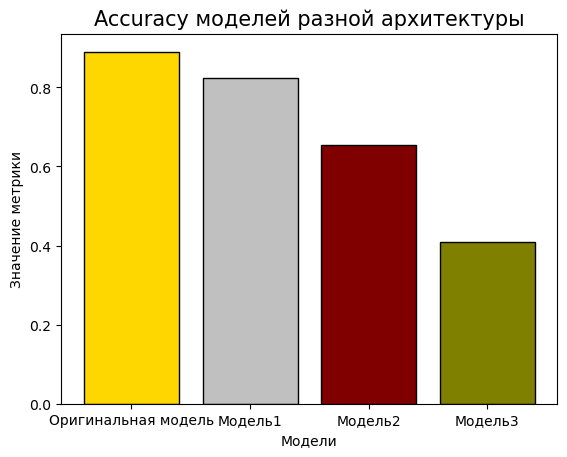

In [47]:
xx = ['Оригинальная модель','Модель1','Модель2','Модель3']
yy = [accuracy.item(),accuracy1.item(),accuracy2.item(),accuracy3.item()]

plt.bar(xx,yy, color=['gold','silver','maroon','olive'],
        edgecolor = 'black')
plt.ylabel('Значение метрики')
plt.xlabel('Модели')

plt.title('Accuracy моделей разной архитектуры', fontsize=15);

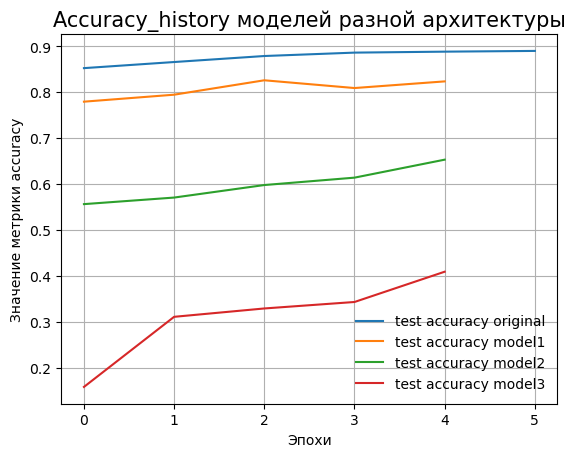

In [48]:
plt.plot(test_accuracy_history, label="test accuracy original")
plt.plot(test_accuracy_history1, label="test accuracy model1")
plt.plot(test_accuracy_history2, label="test accuracy model2")
plt.plot(test_accuracy_history3, label="test accuracy model3")

plt.ylabel('Значение метрики accuracy')
plt.xlabel('Эпохи')

plt.title('Accuracy_history моделей разной архитектуры', fontsize=15);
plt.legend(frameon=False);
plt.grid(True);

plt.show()

# Выбор модели:
Лучшая модель по значениям метрики - оригинальная модель

> ### Результаты выбранных значений гиперпараметров на основе оригинальной модели

In [49]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855883 using {'batch_size': 50, 'max_epochs': 6, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.831183 (0.039657) with: {'batch_size': 50, 'max_epochs': 3, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.821700 (0.012944) with: {'batch_size': 50, 'max_epochs': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.855883 (0.032521) with: {'batch_size': 50, 'max_epochs': 6, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.833517 (0.006952) with: {'batch_size': 50, 'max_epochs': 6, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.793817 (0.078063) with: {'batch_size': 100, 'max_epochs': 3, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.845617 (0.011531) with: {'batch_size': 100, 'max_epochs': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.814117 (0.062298) with: {'batch_size': 100, 'max_epochs': 6, 'optimizer': <class 'torch.optim.sgd.SGD'>}
0.838617 (0.029542) with: {'batch_size': 100, 'max_epochs': 6, 'optimizer': <class 'torch.optim.adam.Adam'>}


> ### Результаты выбранной модели (оригинальная модель)

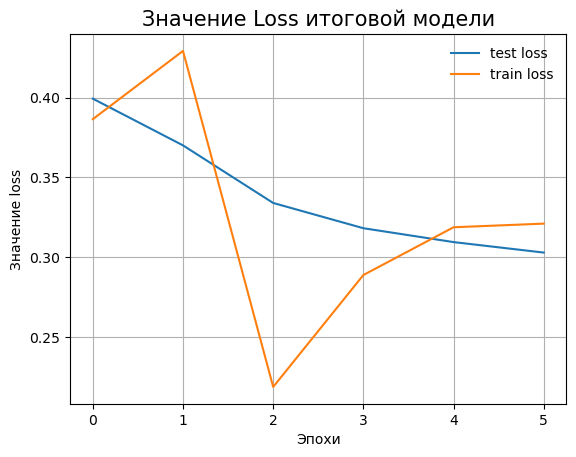

In [50]:
with torch.no_grad():
    plt.plot(test_loss_history, label="test loss")
    plt.plot(train_loss_history, label="train loss")
    
    plt.ylabel('Значение loss')
    plt.xlabel('Эпохи')

    plt.title('Значение Loss итоговой модели', fontsize=15);
    plt.legend(frameon=False);
    plt.grid(True);

    plt.show()

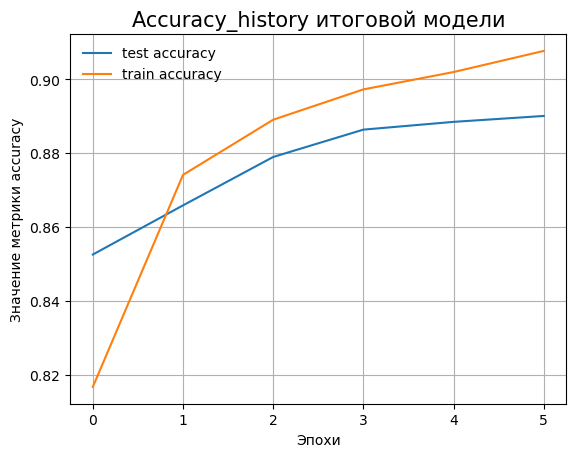

In [51]:
plt.plot(test_accuracy_history, label="test accuracy")
plt.plot(train_accuracy_history, label="train accuracy")

plt.ylabel('Значение метрики accuracy')
plt.xlabel('Эпохи')

plt.title('Accuracy_history итоговой модели', fontsize=15);
plt.legend(frameon=False);
plt.grid(True);

plt.show()

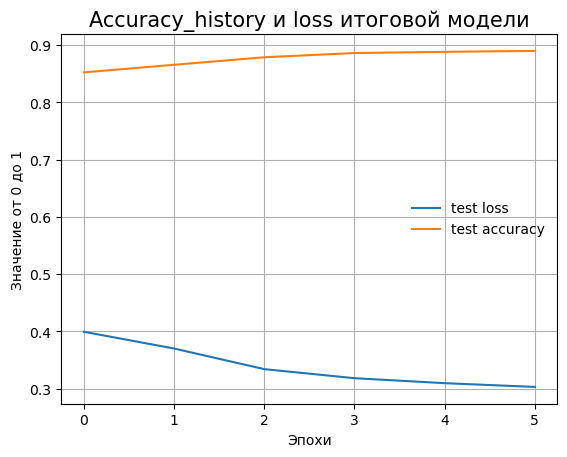

In [52]:
with torch.no_grad():
    plt.plot(test_loss_history, label="test loss")
plt.plot(test_accuracy_history, label="test accuracy")    
plt.ylabel('Значение от 0 до 1')
plt.xlabel('Эпохи')

plt.title('Accuracy_history и loss итоговой модели', fontsize=15);
plt.legend(frameon=False);
plt.grid(True);

plt.show()